## Motivation
![](./resnet_motivation.png)

## The degradation problem
With network depth increasing, accuracy gets saturated and then degrades rapidly. This cannot be explained by over-fitting because the training accuracy is degrading too.

Adding more layers to a suitable deep model leads to higher training error.

## The intuition behind ResNet
Suppose we have a neural network. We can add a few extra layers to make it deeper. If the added layers are identity mappings, then the neural network and its deeper conterpart share the same architecture, thus the deeper network should at least has a good performance as the shallow one.
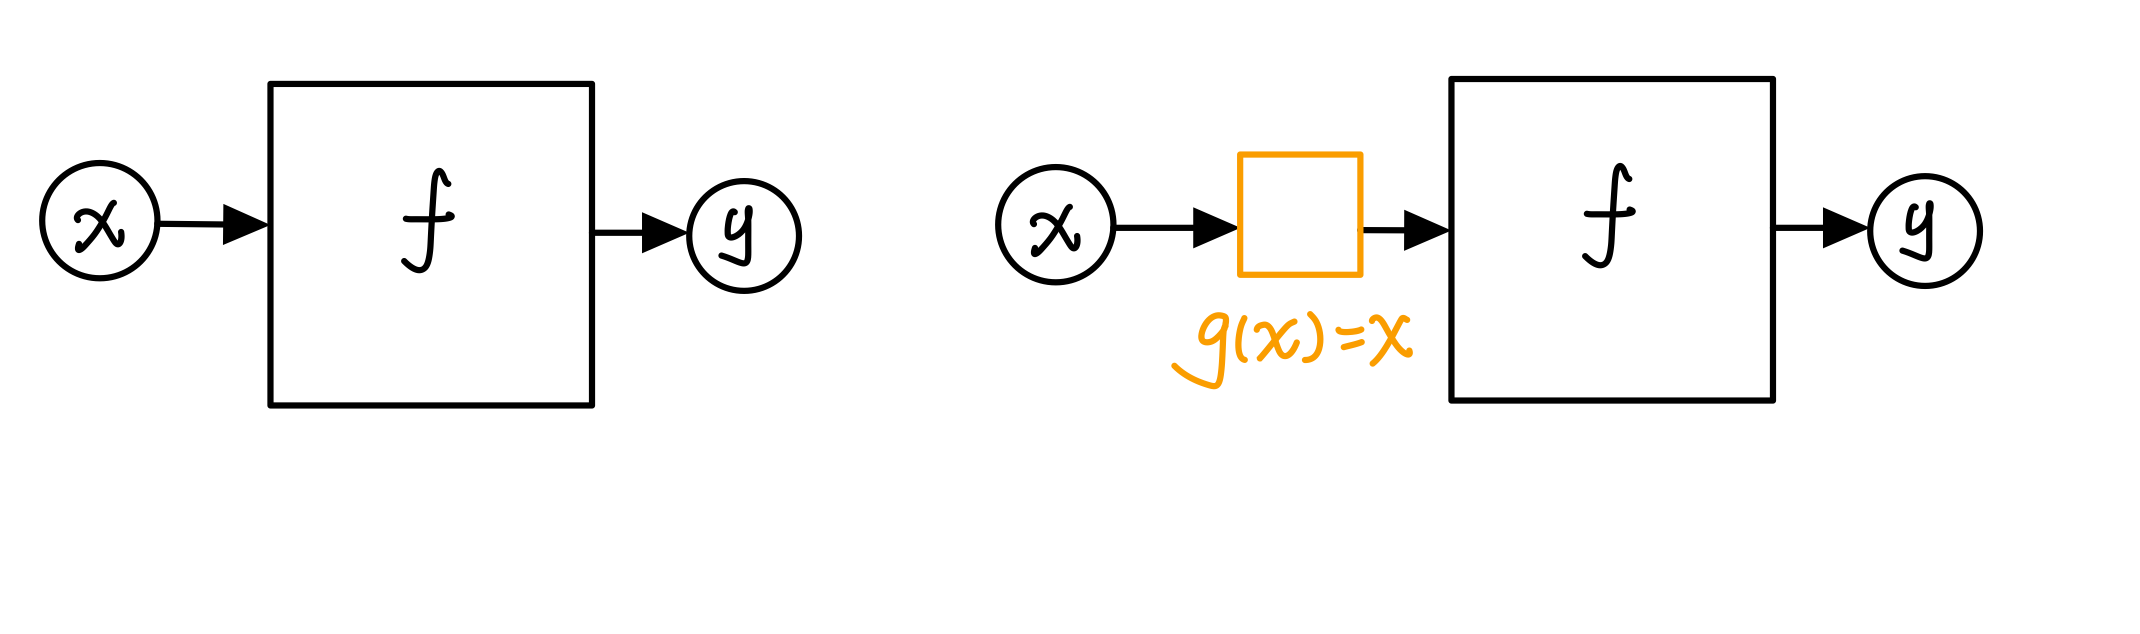

Another perspective is to force the deeper architectrue to nest the shallow one. Please check http://d2l.ai/chapter_convolutional-modern/resnet.html.

## The general form of a residual block

The residual block performs the following computation:
$$\mathbf{y}_l=h(\mathbf{x}_l)+\mathcal{F}(\mathbf{x}_l, \mathcal{W}_l)$$
$$\mathbf{x}_{l+1}=f(\mathbf{y}_l).$$
A residual block is consisted of two parts:
- Function $\mathcal{F}(\mathbf{x}_l, \mathcal{W}_l)$ is the residual part.
- $h(\mathbf{x}_l)$ is the direct mapping part (short-cut).

After the addition of the two parts, the outcome is passed to function $f$.


## The residual block
![](./residual_block.png)

The above residual block requires that the **convolution output must has the same size with the input**. Or else, we need to add an extra $1 \times 1$ convolution to match the dimensions and sizes.

In [13]:
import torch
from torch import nn
from torch.nn import functional as F

In [25]:
class Residual(nn.Module):
    '''
    The residual block of the Resnet.
    '''
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
        

In [26]:
blk = Residual(3, 3, use_1x1conv=True, strides=2)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 3, 3])

## The ResNet
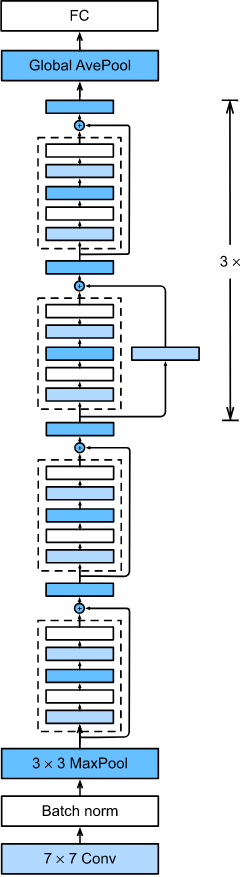

In [27]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [28]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [29]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [30]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [31]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## Dataset

In [32]:
import sys
sys.path.append("../dlutils")
from dataset import load_fashion_mnist_dataset

train_loader, test_loader = load_fashion_mnist_dataset(batch_size=256, resize=96)

## Loss

In [33]:
loss = torch.nn.CrossEntropyLoss()

## Optimizer

In [34]:
trainer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9)

## Train

In [35]:
from train import train_3ch

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
loss.to(device)

train_3ch(net, loss, num_epochs, train_loader, trainer, test_loader, device)

epoch 0, training loss 0.001026, training accuracy 0.903333, testing loss 0.001183, testing accuracy 0.889600
epoch 1, training loss nan, training accuracy 0.100000, testing loss nan, testing accuracy 0.100000
epoch 2, training loss nan, training accuracy 0.100000, testing loss nan, testing accuracy 0.100000
epoch 3, training loss nan, training accuracy 0.100000, testing loss nan, testing accuracy 0.100000
epoch 4, training loss nan, training accuracy 0.100000, testing loss nan, testing accuracy 0.100000
epoch 5, training loss nan, training accuracy 0.100000, testing loss nan, testing accuracy 0.100000
epoch 6, training loss nan, training accuracy 0.100000, testing loss nan, testing accuracy 0.100000
epoch 7, training loss nan, training accuracy 0.100000, testing loss nan, testing accuracy 0.100000
epoch 8, training loss nan, training accuracy 0.100000, testing loss nan, testing accuracy 0.100000
epoch 9, training loss nan, training accuracy 0.100000, testing loss nan, testing accuracy